<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Building Models for Accuracy vs. Speed

This notebook analyses how various parameters influence model accuracy and inference speed. For evaluation, the popular [**COCO**](http://cocodataset.org/#home) dataset is used so that our numbers can be compared to published results. In addition, we manage to reproduce the accuracy of Torchvision's pre-trained Faster R-CNN model reported on their [models](https://pytorch.org/docs/stable/torchvision/models.html) site.

Familiarity with the [01_training_introduction.ipynb](01_training_introduction.ipynb) notebook is assumed, and hence no explanation for repeated concepts or code provided. Instead, we focus on new aspects such as how to evaluate on the COCO dataset, or how to improve speed and accuracy. Training a new model on the COCO dataset, while not covered in this notebook, could be easily added by copying the respective cells from the 01_training_introduction notebook.



## Initialization

Import all the functions we need.

In [1]:
import sys

sys.path.append("../../")

import os
import time
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torchvision

from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import which_processor, is_windows
from utils_cv.detection.data import coco_labels, Urls
from utils_cv.detection.dataset import DetectionDataset
from utils_cv.detection.plot import plot_pr_curves
from utils_cv.detection.model import DetectionLearner, get_pretrained_fasterrcnn

# Change matplotlib backend so that plots are shown for windows
if is_windows():
    plt.switch_backend("TkAgg")

print(f"TorchVision: {torchvision.__version__}")
which_processor()

TorchVision: 0.4.0
('cudart64_100', 0)
Torch is using GPU: Tesla V100-PCIE-16GB


In [2]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Check if a GPU is present, since accuracy computation in detector.evaluate() has a hard constraint on it.

In [3]:
assert torch.cuda.is_available()

---

# Prepare COCO Dataset

#### Download data

The COCO 2017 validation dataset is used in all our experiments following common practice for benchmarking object detection models. In particular, two `.zip` archives need to be downloaded from [http://cocodataset.org](http://cocodataset.org/#download): the actual images [2017 val images (1GB)](http://images.cocodataset.org/zips/val2017.zip) and the ground truth annotations [2017 train/val annotations (241MB)](http://images.cocodataset.org/annotations/annotations_trainval2017.zip).

The two files should be extracted and placed in a root-folder as shown below, with subfolders called *annotationsCOCO* and *images*:
```
/coco2017
+-- annotationsCOCO
|   +-- captions_train2017.json
|   +-- captions_val2017.json
|   +-- ...
+-- images
|   +-- 000000000139.jpg
|   +-- 000000000285.jpg
|   +-- ...
```


#### Convert COCO to VOC

Next, we need to convert the downloaded COCO annotations to Pascal VOC format in order to run this notebook. The function coco2voc does exactly that and only takes seconds to run. In the code below, we assume the COCO images and annotations are in the folder '/data/coco2017/'; the function then creates a new sub-directory called *annotations*. The function also if needed downloads the images provided their urls are specified in the `.json` annotation file.


```python
from utils_cv.detection.data import coco2voc
coco2voc(
    anno_path = "/data/coco2017/annotationsCOCO/instances_val2017.json",
    output_dir = "/data/coco2017/",
    download_images = False
)
```

# Load Images

#### Path to data

The `DATA_PATH` variable should point to the COCO root directory which in the example above is `"/data/coco2017/"`. However, to try this notebook without having to download and convert COCO first, we set it below to use our fridge objects dataset.

In [4]:
# COCO
#DATA_PATH = "/data/coco2017/"
LABELS = coco_labels()[1:]


DATA_PATH = r"C:\Users\pabuehle\Desktop\coco_val2017"



# Fridge objects dataset 
#DATA_PATH = unzip_url(Urls.fridge_objects_path, exist_ok=True)
#LABELS = ["can", "carton", "milk_bottle", "water_bottle"]

The `DATA_PATH` directory, when using COCO, should contain the `annotations`, `images`, and (albeit not used) `annotationsCOCO` folders.


In [5]:
os.listdir(DATA_PATH)

['annotations', 'annotationsCOCO', 'images']

#### Data loading

Most code in this notebook is taken from [01_training_introduction.ipynb](01_training_introduction.ipynb) with only small changes, mainly to ensure the class names (and ordering) in the `DetectionDataset` object matches those used to train the Torchvision model. Hence, in the cell below, we explicitly provide `labels` as input to the detection dataset.

Note that:
- The first element returned by coco_labels() is "\_\_background\_\_" and is removed using `[1:]`.
- We set `allow_negatives = True` since a few of the COCO images don't contain any annotated objects and hence don't have a correspoding `.xml` annotation file.
- The `DetectionDataset` object requires at least 1 image to be assigned to the training set, hence we set `train_pct=0.0001`.

In [13]:
data = DetectionDataset(DATA_PATH, train_pct=0.0001, labels = LABELS, allow_negatives = True)
print(f"Number of test images: {len(data.test_ds)}")

Number of test images: 4999


The plots below summarize some aspects of the annotations, eg. the counts of ground truth boxes per class, or the distribution of absolute and relative widths/heights of the objects. 

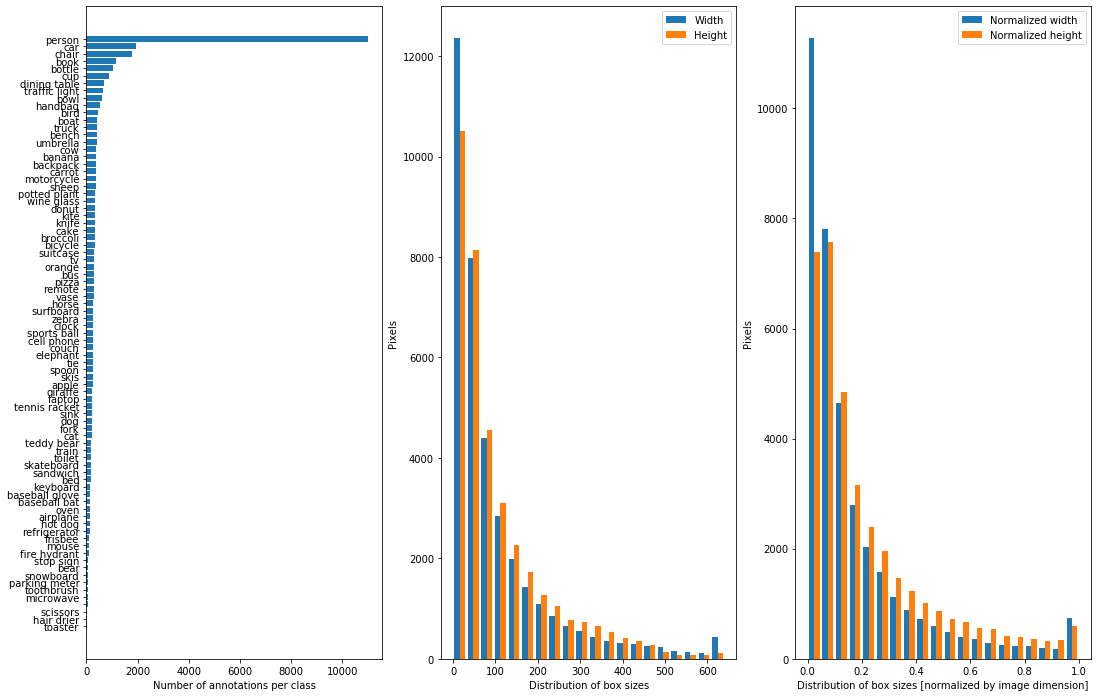

In [7]:
data.plot_boxes_stats(figsize = (18,12))

Lets visualize the annotations to make sure they look correct.

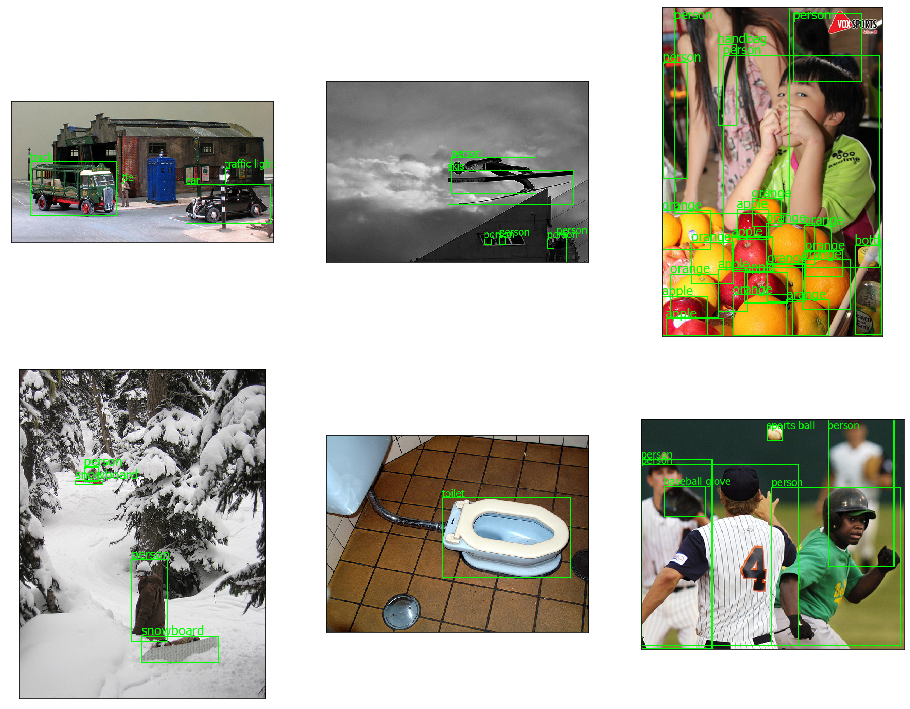

In [8]:
data.show_ims(rows=2)

# Reproduce reported accuracy

The cell below loads the Faster-RCNN model (with FPN) which was trained on COCO. In contrast to the [01_training_introduction.ipynb](01_training_introduction.ipynb) notebook, we want to keep the last layer of the pre-trained model using the function `get_pretrained_fasterrcnn()`.

In [9]:
model = get_pretrained_fasterrcnn()
detector = DetectionLearner(data, model)
print(f"Model: {type(detector.model)}")

Model: <class 'torchvision.models.detection.faster_rcnn.FasterRCNN'>


We can simply run the `evaluate()` method and observe that the mAP in the first row (for IoU=0.50:0.95) is close to the mAP of 37.0 reported on Torchvision's [models](https://pytorch.org/docs/stable/torchvision/models.html) site.

In [10]:
e = detector.evaluate()

creating index...
index created!
Test:  [   0/2500]  eta: 1:31:14  model_time: 2.1740 (2.1740)  evaluator_time: 0.0000 (0.0000)  time: 2.1897  data: 0.0157  max mem: 857
Test:  [ 100/2500]  eta: 0:06:00  model_time: 0.0937 (0.1084)  evaluator_time: 0.0156 (0.0160)  time: 0.1322  data: 0.0250  max mem: 1580
Test:  [ 200/2500]  eta: 0:05:20  model_time: 0.0781 (0.0974)  evaluator_time: 0.0156 (0.0167)  time: 0.1299  data: 0.0219  max mem: 1580
Test:  [ 300/2500]  eta: 0:05:02  model_time: 0.0937 (0.0947)  evaluator_time: 0.0156 (0.0176)  time: 0.1353  data: 0.0242  max mem: 1592
Test:  [ 400/2500]  eta: 0:04:45  model_time: 0.0937 (0.0930)  evaluator_time: 0.0156 (0.0177)  time: 0.1353  data: 0.0219  max mem: 1708
Test:  [ 500/2500]  eta: 0:04:27  model_time: 0.0781 (0.0914)  evaluator_time: 0.0156 (0.0172)  time: 0.1283  data: 0.0235  max mem: 1767
Test:  [ 600/2500]  eta: 0:04:13  model_time: 0.0793 (0.0909)  evaluator_time: 0.0156 (0.0171)  time: 0.1259  data: 0.0250  max mem: 1801
Te

In addition to the average precision/recall numbers, we can also plot the precision-recall curves for different IOU thresholds.

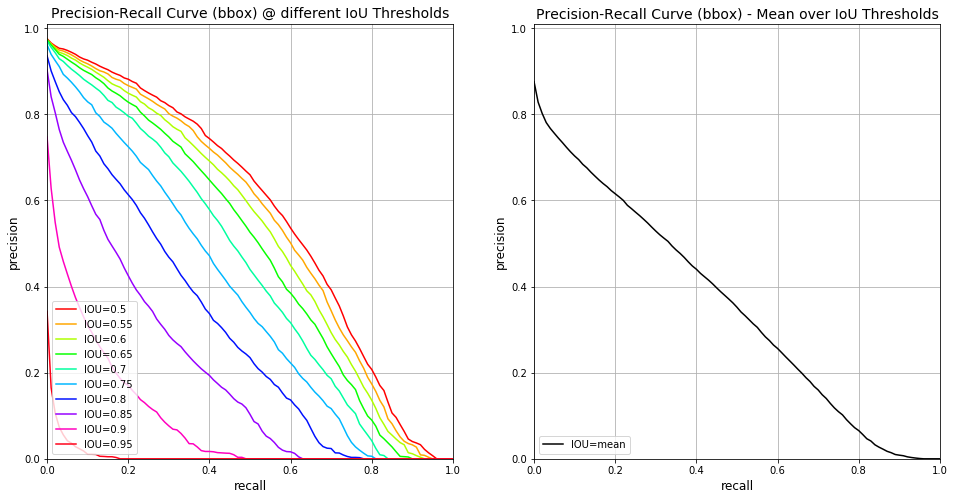

In [11]:
plot_pr_curves(e)

# Inference speed versus accuracy

**THIS SECTION WILL BE ADDED SOON**.

# Conclusion

This notebook illustrated the trade-off from different parameters on inference time and accuracy. Additionnaly, code samples are given to evaluate a model on the the popular COCO dataset, and to reproduced the published accuracy of Torchvision's pre-trained Faster R-CNN model reported on their [models](https://pytorch.org/docs/stable/torchvision/models.html) site.